In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Nhập dữ liệu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Phân tích feature

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


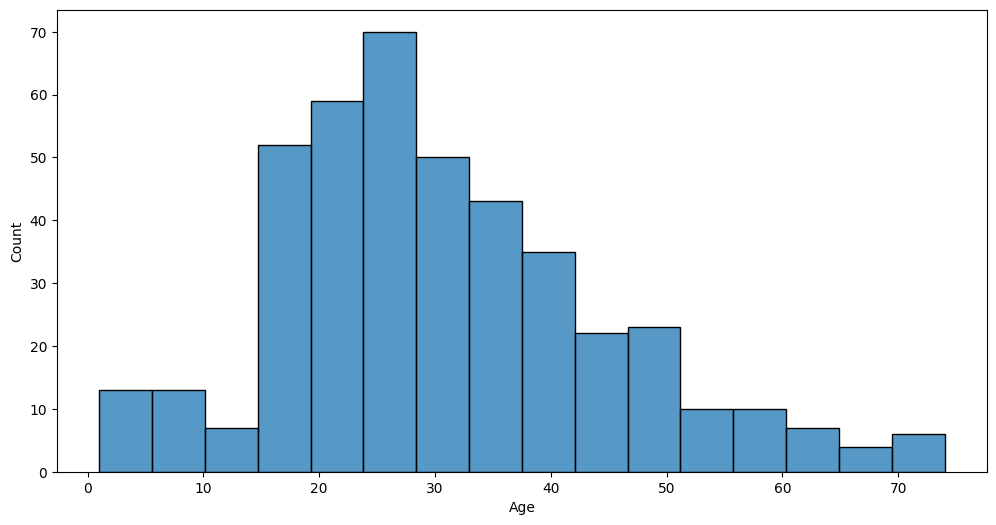

In [5]:
plt.figure(figsize = (12, 6))
count = train[train['Survived'] == 0]
sns.histplot(count, x = 'Age')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


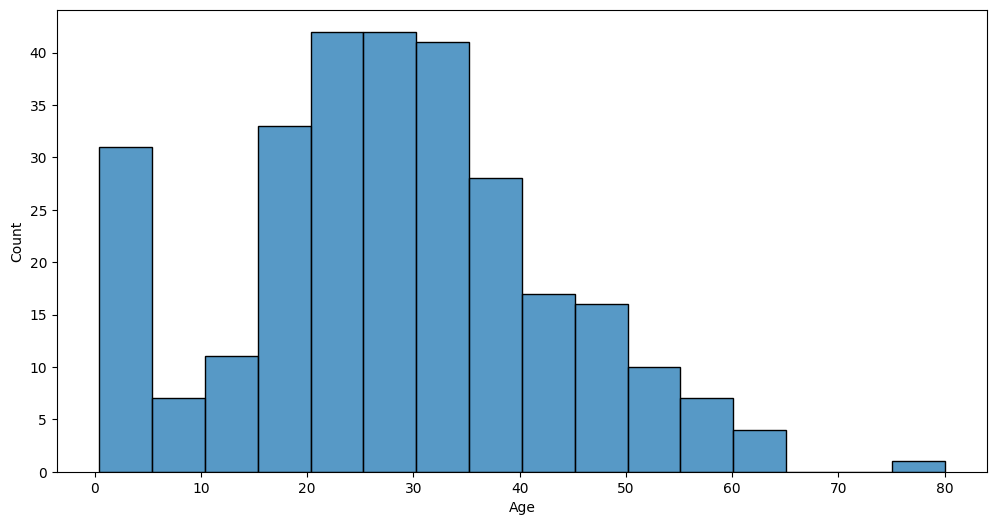

In [6]:
plt.figure(figsize = (12, 6))
count = train[train['Survived'] == 1]
sns.histplot(count, x = 'Age')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


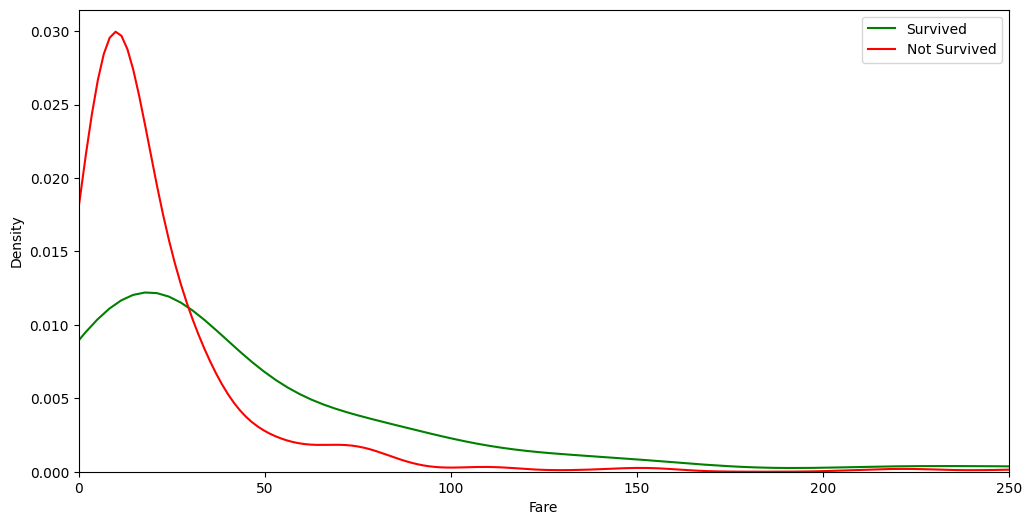

In [7]:
plt.figure(figsize = (12, 6))
sns.kdeplot(train['Fare'][train.Survived == 1], color="green")
sns.kdeplot(train['Fare'][train.Survived == 0], color="red")
plt.legend(['Survived', 'Not Survived'])
plt.xlim(0, 250)
plt.show()

# Xử lý giá trị thiếu

## Age

In [8]:
titles = set()
for name in train['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

print(titles)

{'Mme', 'Jonkheer', 'Don', 'Col', 'Miss', 'Master', 'Mlle', 'Capt', 'Ms', 'Major', 'Sir', 'Rev', 'Dr', 'the Countess', 'Lady', 'Mrs', 'Mr'}


In [9]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty",
    "Dona": "Royalty"
}

def get_titles(df):
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    df['Title'] = df.Title.map(Title_Dictionary)
    return df

In [10]:
train = get_titles(train)
test = get_titles(test)

In [11]:
grouped_train = train.groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median(numeric_only=True)
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

grouped_median_train.head()

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0


In [12]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age(df):
    df['Age'] = df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return df

train = process_age(train)
test = process_age(test)

## Embarked

In [13]:
train['Embarked'] = train['Embarked'].fillna('S')

In [14]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Title            0
dtype: int64

In [15]:
test['Embarked'] = test['Embarked'].fillna(test['Embarked'].mode())

## Fare

In [16]:
test[test['Fare'].isnull()]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr


In [17]:
test['Fare'] = test['Fare'].fillna(test[test['Pclass'] == 3]['Fare'].median())

## Cabin

In [18]:
train = train.drop('Cabin', axis = 1)
test = test.drop('Cabin', axis = 1)

In [19]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64

In [20]:
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64

# Create Feature

## From Cabin

## From Name

In [21]:
train['Surname'] = train['Name'].apply(lambda x: x.split(',')[0])
test['Surname'] = test['Name'].apply(lambda x: x.split(',')[0])

## From Sib..

In [22]:
train['Family_size'] = train['SibSp'] + train['Parch'] + 1
test['Family_size'] = test['SibSp'] + train['Parch'] + 1

In [23]:
train['is_large_family'] = train['Family_size'] > 4
test['is_large_family'] = test['Family_size'] > 4

## From ticket

In [24]:
train['ticket_freq'] = train['Ticket'].map(train['Ticket'].value_counts())
train['fare_freq'] = train['Fare'].map(train['Fare'].value_counts())
test['ticket_freq'] = test['Ticket'].map(test['Ticket'].value_counts())
test['fare_freq'] = test['Fare'].map(test['Fare'].value_counts())

## From Fare

In [25]:
train['has_fare'] = train['Fare'] != 0
test['has_fare'] = test['Fare'] != 0

In [26]:
train['fare_per_ticket'] = train['Fare']/train['ticket_freq']
test['fare_per_ticket'] = test['Fare']/test['ticket_freq']

In [27]:
train['fare_band'] = pd.qcut(train['fare_per_ticket'], 5, labels=[0, 1, 2, 3, 4])
test['fare_band'] = pd.qcut(test['fare_per_ticket'], 5, labels=[0, 1, 2, 3, 4])

In [28]:
def find_age_band(age):
    if age < 14:
        return 0
    elif age <= 30:
        return 2
    elif age <= 64:
        return 1
    else: 
        return 3

train['age_band'] = train['Age'].apply(find_age_band)
train['is_minor'] = train['age_band'] == 0
test['age_band'] = test['Age'].apply(find_age_band)
test['is_minor'] = test['age_band'] == 0

## From Embarked

In [29]:
train['embarked_C'] = train['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
test['embarked_C'] = test['Embarked'].apply(lambda x: 1 if x == 'C' else 0)

# Advance

In [30]:
train['Ticket_formatted'] = train['Embarked'] + '-' + train['Ticket'].astype(str).str[:-2] + 'XX-' + train['Fare'].astype(str)
test['Ticket_formatted'] = test['Embarked'] + '-' + test['Ticket'].astype(str).str[:-2] + 'XX-' + test['Fare'].astype(str)

In [31]:
train['group_id'] = train['Surname'] + '-' + train['Pclass'].astype(str) + '-' + train['Ticket_formatted']
test['group_id'] = test['Surname'] + '-' + test['Pclass'].astype(str) + '-' + test['Ticket_formatted']

In [32]:
train.loc[train['Title'] == 'Mr', 'group_id'] = 'no_group'
test.loc[test['Title'] == 'Mr', 'group_id'] = 'no_group'

In [33]:
group_fred = train['group_id'].value_counts()
train['group_fred'] = train['group_id'].map(group_fred)
group_fred = test['group_id'].value_counts()
test['group_fred'] = test['group_id'].map(group_fred)

In [34]:
train.loc[train['group_fred'] <= 1, 'group_id'] = 'no_group'
test.loc[test['group_fred'] <= 1, 'group_id'] = 'no_group'

In [35]:
group_df = train[train['group_id'] != 'no_group']
for i, row in train.iterrows():
    if row['group_id'] == 'no_group' and row['Title'] != 'Mr':
        same_ticket = group_df[group_df['Ticket_formatted'] == row['Ticket_formatted']]
        if not same_ticket.empty:
            train.at[i, 'group_id'] = same_ticket.iloc[0]['group_id']

In [36]:
group_df = test[test['group_id'] != 'no_group']
for i, row in test.iterrows():
    if row['group_id'] == 'no_group' and row['Title'] != 'Mr':
        same_ticket = group_df[group_df['Ticket_formatted'] == row['Ticket_formatted']]
        if not same_ticket.empty:
            test.at[i, 'group_id'] = same_ticket.iloc[0]['group_id']

In [37]:
train['group_fred'] = train['group_id'].map(train['group_id'].value_counts())
test['group_fred'] = test['group_id'].map(test['group_id'].value_counts())

In [38]:
group_survival = train.groupby('group_id')['Survived'].mean()
train['group_survival'] = train['group_id'].map(group_survival)
test['group_survival'] = test['group_id'].map(group_survival)

In [39]:
def get_avg_survival(row):
    if row['group_id'] != 'no_group':
        return row['group_survival']
    subset = train[
        (train['group_id'] == 'no_group') &
        (train['Pclass'] == row['Pclass']) &
        (train['Sex'] == row['Sex'])
    ]
    return subset['Survived'].mean()

train['group_survival'] = train.apply(get_avg_survival, axis=1)
test['group_survival'] = test.apply(get_avg_survival, axis=1)

In [40]:
def fill_missing_survival(row):
    if pd.isna(row['group_survival']):
        same_freq = train[train['group_fred'] == row['group_fred']]
        return same_freq['group_survival'].mean()
    return row['group_survival']

train['group_survival'] = train.apply(fill_missing_survival, axis=1)
test['group_survival'] = test.apply(fill_missing_survival, axis=1)

# Data Preparation

In [41]:
def dummy_encoding(df, feature):
    dummies = pd.get_dummies(df[feature], prefix=feature, drop_first=True)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop(feature, axis=1)
    return df

In [42]:
def prepare_features(df, features):
    """Make the feature usable by an ML algorithm"""
    df = df.copy()
    
    for col in df.columns:
        if col not in features['nominal'] + features['ordinal'] \
            + features['boolean'] + features['numeric'] + ['is_train', 'Survived']:
            df = df.drop(col, axis=1)
    
    # Transform useful features
    for feature in features['nominal']:
        df[feature] = df[feature].astype('category')
        df = dummy_encoding(df, feature)
    
    for feature in features['ordinal'] + features['boolean']:
        df[feature] = df[feature].astype('int')
    
    for feature in features['ordinal'] + features['numeric']:
        scaler = StandardScaler()
        df[[feature]] = scaler.fit_transform(df[[feature]])
        df[feature + '_scaled'] = df[feature]
        df = df.drop(feature, axis=1)
    
    return df

In [43]:
features = {
    'nominal': ['Sex'], # sex*pclass, 'title'
    'ordinal': ['Pclass', 'fare_band'], # 'age_band'
    'boolean': ['is_minor'], # 'embarked_C', 'is_large_family', 'has_fare', 'is_minor'
    'numeric': ['group_survival'], # ['fare_per_ticket', 'Age']
}
train_prepared = prepare_features(train, features)
test_prepared = prepare_features(test, features)

# Modeling

In [44]:
X = train_prepared.drop('Survived', axis = 1);
y = train_prepared['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

models = {"Logistic Regression": LogisticRegression(random_state = 42, max_iter = 1000),
         "Random Forest" : RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators = 200),
         "XGBoost": XGBClassifier(use_label_encoder = False, eval_metric = "logloss", random_state = 42, n_jobs = -1),
         "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=42)}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    print(f"{name} Results: ")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print("-" * 30)

Logistic Regression Results: 
  Accuracy: 0.8324
  F1 Score: 0.7692
  ROC AUC: 0.8794
------------------------------
Random Forest Results: 
  Accuracy: 0.8324
  F1 Score: 0.7761
  ROC AUC: 0.8877
------------------------------
XGBoost Results: 
  Accuracy: 0.8324
  F1 Score: 0.7656
  ROC AUC: 0.8835
------------------------------
Gradient Boosting Classifier Results: 
  Accuracy: 0.8380
  F1 Score: 0.7752
  ROC AUC: 0.8797
------------------------------


In [46]:
best_model = RandomForestClassifier(
    random_state=2,
    n_estimators=25,
    min_samples_split=20,
    oob_score=True)
best_model.fit(X_train, y_train)
y_val_pred = best_model.predict(X_test)

In [47]:
test_data_orig = pd.read_csv("/kaggle/input/titanic/test.csv")

# X_final = scaler.transform(test)
# X_final_ica = ica.transform(X_final)
# test_preds = best_model.predict(X_final_ica)
test_preds = best_model.predict(test_prepared)

submission = pd.DataFrame({
    "PassengerId" : test_data_orig["PassengerId"],
    "Survived" : test_preds
})

submission.to_csv("Submission.csv", index=False)
print("Submission file 'submission.csv' created.")

Submission file 'submission.csv' created.
